# Leakage-Aware Decoding with the Local Clustering Decoder

*Want to follow along? {nb-download}`Download this notebook.<leakage-aware_decoding.ipynb>`*

In this notebook, we demonstrate leakage-aware decoding with Riverlane's proprietary Local Clustering Decoder (LCD). In particular, we

* introduce the LCD and cover what leakage noise is and why it is a problematic source of noise for fault-tolerant quantum computation;
* read-in circuits of surface codes and consider two leakage noise levels: low leakage (LL) and high leakage (HL);
* generate measurement, detector, and observable data from the circuits;
* decode the detector data thrice with LCD: once leakage-unaware (LU), once leakage-aware (LA), and once weighted leakage-aware (WLA);
* produce a plot of the logical error rate per round against code distance and calculate $\Lambda$, the error suppression factor for the 6 decoding examples $\{LL,\;HL\} \times \{LU,\;LA,\;WLA\}$, demonstrating the improvement to logical error suppression through decoding with leakage awareness.

**Note:** The compilation of the adaptivity map, which happens ahead of runtime and sampling, is computationally intense, but sampling and decoding are fast. For higher code distances compilation times can be long. If you wish to run this notebook yourself, we strongly recommend selecting a subset of the distances and a lower number of shots (d = [5, 7, 9], shots ≥ 250,000). This is already included by default with the full experiment commented-out at the top of the ``Circuit Simulation and Decoding`` section code block.

## Introduction
The [Local Clustering Decoder](https://arxiv.org/pdf/2411.10343) is the first surface code decoder that retains the performance advantage offered by hardware decoders, while obtaining levels of accuracy and flexibility competitive with software counterparts. LCD is an adaptive and distributed version of an error-clustering algorithm based on Union-Find. Adaptivity refers to updating LCD's error prior based on runtime events, such as heralded leaked qubit measurements. In this notebook, we demonstrate the benefits of LCD by decoding a surface code patch under a circuit-level noise model with leakage — a damaging correlated noise channel affecting most qubit types. We observe a significant improvement in the error-correction performance when leakage adaptivity is included, effectively halving the code distance d required for computation.

Leakage is a problematic source of noise in quantum circuits. It refers to the tendency for qubits to drift out of the computational states ($|0\rangle$ and $|1\rangle$) to higher energy leaked states ($|2\rangle$, $|3\rangle$, etc). Unlike erasure, leakage is silent until measurement. Leakage also differs from conventional Pauli noise — it is long-lived and may spread subsequent noise to other qubits through multi-qubit interactions. This leads to correlated errors in spacetime, which can severely degrade the exponential suppression of logical error that comes with increasing numbers of data qubits in quantum error correction (QEC). Therefore, it is imperative to mitigate the damage of leakage noise both through circuit design with leakage-reduction units and designing decoders that consider its effects. See for example [Coping with qubit leakage in topological codes](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.88.042308).

In [ ]:
# Perform necessary imports
from __future__ import annotations

from pathlib import Path

import matplotlib.pyplot as plt
from deltakit.explorer import analysis, Client, enums, types
from tqdm import tqdm

# Set up server instance
client = Client.get_instance()
# Specify circuit and data folders
circuits_folder = Path("../..") / "data/leakage/pre-generated_circuits"

## Read-in circuits
We read in circuits for quantum memory experiments in a $d \times d \times d$ surface code, where $d \in \{5, 7, 9, 11, 13\}$. These circuits are subject to a noise model with leakage. Our noise model is an extension of the SI1000 noise model, as described in [Local Clustering Decoder: a fast and adaptive hardware decoder for the surface code](https://arxiv.org/abs/2411.10343). SI1000 is a one-parameter model describing noise in superconducting systems. This parameter $p$ can be taken to be the noise of 2-qubit gates. Our noise model supplements SI1000 with a second parameter, $p_l$, representing the probability that a 2-qubit gate causes a qubit to leak. Leakage may also occur upon reset. A leaked qubit fully depolarises other qubits via 2-qubit gates. Once a qubit is leaked, it can relax back to the computational subspace through relaxation processes, which have their own probability. Eg, qubit resets relax leaked qubits with 100% probability, while 2-qubit gates relax with the same probability they leak: $p_l$.

Our circuits contain a leakage reduction unit (LRU) known as patch wiggling, introduced in [Relaxing Hardware Requirements for Surface Code Circuits using Time-dynamics](https://quantum-journal.org/papers/q-2023-11-07-1172/#). This LRU is a small modification in the standard syndrome-extraction (SE) circuits that achieves a role-exchange between data and auxiliary qubits at every round SE. This ensures that every physical qubit is reset every two rounds of SE, flushing regularly leakage from all qubits, and limiting the longevity of leakage to two rounds of SE.

We explore two different parametrisations of our SI1000+leakage noise model, where leakage is both a dominant and subdominant error mechanism by setting $p$ and $p_l$ as follows:
1. **Low leakage (LL)**: $p$ = 10<sup>-3</sup> and $p_l$ = 10<sup>-4</sup>.
2. **High Leakage (HL)**: $p$ = $p_l$ = 5 $\times$ 10<sup>-4</sup>.

In our circuits, leakage and relaxation processes are represented as noise channels, that our leakage simulator can interpret.  Our simulator is an extension of [Stim: a fast stabilizer circuit simulator](https://quantum-journal.org/papers/q-2021-07-06-497/#). The figure below is an example circuit diagram for a 3x3 surface code with wiggling; run for 2 rounds. In the diagram, the

- Orange boxes are Leakage channels;
- Blue boxes are Relaxation channels;
- Pink boxes are Pauil noise channels of X error, 1-qubit depolarizing and 2-qubit depolarizing noise;
- Black boxes are Measurement or Reset gates;
- White boxes are Hadamard gates;
- Grey rectangles are Detectors.

![3x3x2 wiggling circuit](3x3_wiggling_circuit.svg)

## Read-In Circuits and define experiment

In [2]:
distances = [5, 7, 9]
num_shots = 500000

all_circuits = {"LL" : [], "HL" : []}

# Read-in selected circuits
for rounds in distances:
    all_circuits["LL"].append(circuits_folder / f"heralded_qmem_rplanar_{rounds}x{rounds}x{rounds}_perr_0.001_pL_0.0001_with_wiggling.stim")
    all_circuits["HL"].append(circuits_folder / f"heralded_qmem_rplanar_{rounds}x{rounds}x{rounds}_perr_0.0005_pL_0.0005_with_wiggling.stim")

## Circuit Simulation and Decoding
We simulate each circuit for 500k shots, before decoding with the LCD decoder in 3 different configurations: without leakage awareness (LU), with unweighted leakage awareness (LA), and with weighted leakage awareness (WLA). The LU configuration converts a measurement of a leaked qubit into a random 0/1 result, and decodes without using the information that the qubit was leaked. The LA configuration uses the leakage information to update the prior for the noise, by assuming that the measured leaked qubit fully depolarised all qubits it interacted with via 2-qubit gates since the previous reset. The WLA configuration assumes a linearly increasing probability of leakage from the previous reset (0%) to the leakage measurement event (100%), and weights the probability of depolarising nearby qubit via 2-qubits accordingly. See [Leakage suppression in the Toric code](https://arxiv.org/abs/1410.8562) for an earlier implementation of similar ideas.

In [3]:
def simulate_and_decode(
    noisy_circuit: str,
    leakage_aware: bool, weighted: bool,
) -> types.DecodingResult:

    measurements, leakage = client.simulate_stim_circuit(
        stim_circuit=noisy_circuit,
        shots=num_shots,
    )
    detectors, observables = measurements.to_detectors_and_observables(noisy_circuit)

    decoder = types.Decoder(
        decoder_type=enums.DecoderType.LCD,
        use_experimental_graph=False,
        parallel_jobs=4,
        parameters={"weighted": weighted},
    )
    # provide leakage heralding data to perform leakage aware decoding
    return client.decode(
        detectors=detectors,
        observables=observables,
        decoder=decoder,
        noisy_stim_circuit=noisy_circuit,
        leakage_flags=leakage if leakage_aware else None,
    )


all_decoding_results = {"leakage_unaware" : {"LL" : [], "HL" : []},
                        "leakage_aware" : {"LL" : [], "HL" : []},
                        "weighted_leakage_aware" : {"LL" : [], "HL" : []}}

# Perform leakage-unaware, leakage-aware, and weighted leakage-aware decoding
for awareness in all_decoding_results:
    for noise_level, circuits in all_circuits.items():
        decoding_results = []
        for circuit_file in tqdm(circuits):
            with open(circuit_file, encoding="utf-8") as cfile:
                circuit = cfile.read()
            decoding_results.append(
                simulate_and_decode(
                    noisy_circuit=circuit,
                    leakage_aware=(awareness != "leakage_unaware"),
                    weighted=(awareness == "weighted_leakage_aware")
                )
            )
        all_decoding_results[awareness][noise_level] = decoding_results

Performing circuit simulation and leakage_unaware decoding with LL noise model:


100%|██████████| 3/3 [07:03<00:00, 141.01s/it]


Performing circuit simulation and leakage_unaware decoding with HL noise model:


100%|██████████| 3/3 [06:51<00:00, 137.11s/it]


Performing circuit simulation and leakage_aware decoding with LL noise model:


  0%|          | 0/3 [00:00<?, ?it/s][2025-06-10 17:07:40,512.512][deltakit-explorer][WARNING] wrapper: Simulation will be performed in batches of 100000 shots. | reqid=[decorator]
[2025-06-10 17:08:18,631.631][deltakit-explorer][WARNING] wrapper: Leakage-aware decoding has a heavy initialisation part. Big tasks may be cancelled by server timeout. | reqid=[decorator]
 33%|███▎      | 1/3 [00:55<01:51, 55.70s/it][2025-06-10 17:08:36,215.215][deltakit-explorer][WARNING] wrapper: Simulation will be performed in batches of 100000 shots. | reqid=[decorator]
[2025-06-10 17:10:12,188.188][deltakit-explorer][WARNING] wrapper: Leakage-aware decoding has a heavy initialisation part. Big tasks may be cancelled by server timeout. | reqid=[decorator]
 67%|██████▋   | 2/3 [03:24<01:50, 110.43s/it][2025-06-10 17:11:04,953.953][deltakit-explorer][WARNING] wrapper: Simulation will be performed in batches of 100000 shots. | reqid=[decorator]
[2025-06-10 17:14:19,440.440][deltakit-explorer][WARNING] wrap

Performing circuit simulation and leakage_aware decoding with HL noise model:


  0%|          | 0/3 [00:00<?, ?it/s][2025-06-10 17:16:34,781.781][deltakit-explorer][WARNING] wrapper: Simulation will be performed in batches of 100000 shots. | reqid=[decorator]
[2025-06-10 17:17:12,737.737][deltakit-explorer][WARNING] wrapper: Leakage-aware decoding has a heavy initialisation part. Big tasks may be cancelled by server timeout. | reqid=[decorator]
 33%|███▎      | 1/3 [00:55<01:51, 55.85s/it][2025-06-10 17:17:30,632.632][deltakit-explorer][WARNING] wrapper: Simulation will be performed in batches of 100000 shots. | reqid=[decorator]
[2025-06-10 17:19:07,299.299][deltakit-explorer][WARNING] wrapper: Leakage-aware decoding has a heavy initialisation part. Big tasks may be cancelled by server timeout. | reqid=[decorator]
 67%|██████▋   | 2/3 [03:31<01:54, 114.84s/it][2025-06-10 17:20:06,771.771][deltakit-explorer][WARNING] wrapper: Simulation will be performed in batches of 100000 shots. | reqid=[decorator]
[2025-06-10 17:23:26,304.304][deltakit-explorer][WARNING] wrap

Performing circuit simulation and weighted_leakage_aware decoding with LL noise model:


  0%|          | 0/3 [00:00<?, ?it/s][2025-06-10 17:25:55,598.598][deltakit-explorer][WARNING] wrapper: Simulation will be performed in batches of 100000 shots. | reqid=[decorator]
[2025-06-10 17:26:34,379.379][deltakit-explorer][WARNING] wrapper: Leakage-aware decoding has a heavy initialisation part. Big tasks may be cancelled by server timeout. | reqid=[decorator]
 33%|███▎      | 1/3 [00:56<01:53, 56.98s/it][2025-06-10 17:26:52,580.580][deltakit-explorer][WARNING] wrapper: Simulation will be performed in batches of 100000 shots. | reqid=[decorator]
[2025-06-10 17:28:32,695.695][deltakit-explorer][WARNING] wrapper: Leakage-aware decoding has a heavy initialisation part. Big tasks may be cancelled by server timeout. | reqid=[decorator]
 67%|██████▋   | 2/3 [03:30<01:54, 114.02s/it][2025-06-10 17:29:26,533.533][deltakit-explorer][WARNING] wrapper: Simulation will be performed in batches of 100000 shots. | reqid=[decorator]
[2025-06-10 17:32:43,266.266][deltakit-explorer][WARNING] wrap

Performing circuit simulation and weighted_leakage_aware decoding with HL noise model:


  0%|          | 0/3 [00:00<?, ?it/s][2025-06-10 17:35:00,763.763][deltakit-explorer][WARNING] wrapper: Simulation will be performed in batches of 100000 shots. | reqid=[decorator]
[2025-06-10 17:35:38,753.753][deltakit-explorer][WARNING] wrapper: Leakage-aware decoding has a heavy initialisation part. Big tasks may be cancelled by server timeout. | reqid=[decorator]
 33%|███▎      | 1/3 [00:56<01:52, 56.06s/it][2025-06-10 17:35:56,826.826][deltakit-explorer][WARNING] wrapper: Simulation will be performed in batches of 100000 shots. | reqid=[decorator]
[2025-06-10 17:37:37,451.451][deltakit-explorer][WARNING] wrapper: Leakage-aware decoding has a heavy initialisation part. Big tasks may be cancelled by server timeout. | reqid=[decorator]
 67%|██████▋   | 2/3 [03:32<01:54, 114.90s/it][2025-06-10 17:38:32,919.919][deltakit-explorer][WARNING] wrapper: Simulation will be performed in batches of 100000 shots. | reqid=[decorator]
[2025-06-10 17:41:49,410.410][deltakit-explorer][WARNING] wrap

### Results

In [4]:
# Reorganise decoding results into a list of named tuples
from collections import namedtuple

LeakageDecodingReport = namedtuple("LeakageDecodingReport",
                            ["awareness", "noise_level", "fails", "shots"])

def extract_results(result, awareness, noise_level):
    fails, shots = [], []
    for res in result:
        fails.append(res.fails)
        shots.append(res.shots)

    return LeakageDecodingReport(awareness, noise_level, fails, shots)

decoding_results = []
for awareness in all_decoding_results:
    for noise_level, result in all_decoding_results[awareness].items():
        decoding_results.append(extract_results(result, awareness, noise_level))

## Plot results and calculate $\Lambda$
Below we plot the logical error probability per round, $P_L$, for each of our $d \times d \times d$ circuits as a function of $d$. This is computed by dividing the logical error probability (the ratio of fails to shots) for each circuit by the number of rounds in the given circuit. We then fit the data to a function of the form $P_L \propto \Lambda^{-d/2}$ via a weighted linear fit in a log-linear scale, and report the corresponding values of $\Lambda$. In the plot, orange-coloured lines represent the LL noise model, whilst teal-coloured lines are the HL noise model.

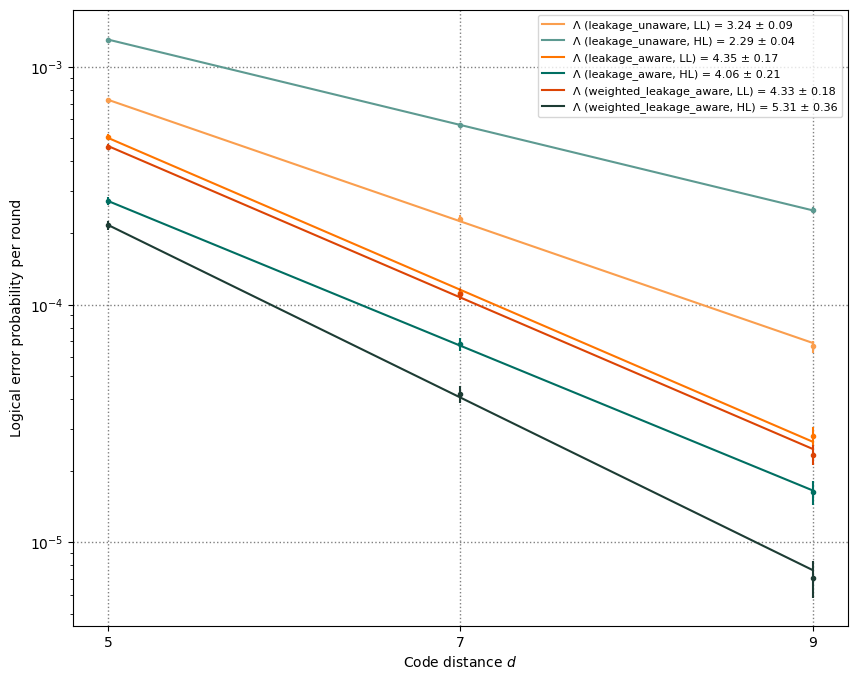

In [ ]:
def calculate_lambda_and_plot_points(results, colour):
    p_l, p_l_stddev = analysis.calculate_lep_and_lep_stddev(
        fails=results.fails,
        shots=results.shots
	)
    # Since we have dxdxd circuits, divide by distance to get per-round p_l
    p_l_per_round = p_l / distances    # Note this is an approximation, valid for small p_l
    p_l_stddev_per_round = p_l_stddev / distances
    lambda_value, lambda_value_stddev = analysis.calculate_lambda_and_lambda_stddev(
        distances=distances,
        lep_per_round=p_l_per_round,
        lep_stddev_per_round=p_l_stddev_per_round
    )
    lep_per_round_fit = analysis.get_lambda_fit(
        distances=distances,
        lep_per_round=p_l_per_round,
        lep_stddev_per_round=p_l_stddev_per_round
    )
    # Plot the logical error probability per round against distance with error bars
    plt.errorbar(distances, p_l_per_round, yerr=p_l_stddev_per_round, fmt=".", color=colour)
    # Plot weighted linear regression fit
    plt.plot(distances, lep_per_round_fit,
             label=f"Λ ({results.awareness}, {results.noise_level}) = {lambda_value:.2f} ± {lambda_value_stddev:.2f}",
             color=colour
    )
plt.figure(figsize=(10, 8))
colour_palette = ["#fa9e4e", "#5d9a91", "#ff7500", "#006f62", "#dc4405", "#1d3c34"]
for dec_res, colour in zip(decoding_results, colour_palette):
    calculate_lambda_and_plot_points(dec_res, colour)

plt.grid(color="gray", linestyle=":", linewidth=1)
plt.xticks(distances)
plt.xlabel("Code distance $d$")
plt.ylabel("Logical error probability per round")
plt.yscale("log")
plt.legend(fontsize=8)
plt.show()

## Discussion
We note that, for a fixed error model and decoder configuration, $\Lambda$ is larger in our plot compared to the paper [Local Clustering Decoder: a fast and adaptive hardware decoder for the surface code](https://arxiv.org/abs/2411.10343). This is because the hardware implementation of decoder in the paper uses an unweighted graph error model, whereas here we have used a more accurate weighted graph.  We can see that, as in the paper, $\Lambda$ increases from LU to LA (to WLA), which captures the increased accuracy of the leakage-aware settings of LCD.  This increase in accuracy is more pronounced in the noise model where leakage dominates (HL, teal curves), where going from LU to WLA roughly squares the value of $\Lambda$. In practice, this means that with leakage awareness we can attain the same target logical accuracy with half the distance compared to with leakage unawareness. This corresponds to leakage awareness delivering a 75% savings in the number of qubits required for QEC to deliver a desired target logical performance.